In [ ]:
!!pip install emoji==1.6.3
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
import pandas as pd
import re
import string
import emoji
from datasets import Dataset
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

SEED = 42

In [ ]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1', parse_dates=['TweetAt'], dayfirst=True)
df_test = pd.read_csv('Corona_NLP_test.csv',encoding='ISO-8859-1', parse_dates=['TweetAt'], dayfirst=True)
merged_tweets = pd.concat([df, df_test], ignore_index=True)

## EDA

Text(0.5, 1.0, 'Χρονολογική Κατανομή των Tweets')

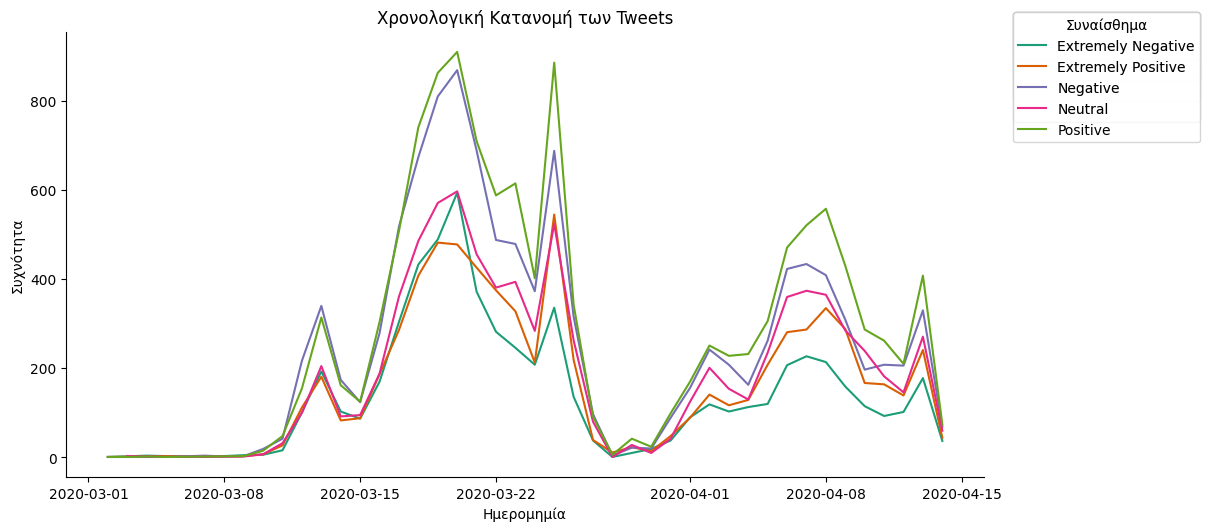

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TweetAt']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TweetAt'}, axis=1)
              .sort_values('TweetAt', ascending=True))
  xs = counted['TweetAt']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_tweets.sort_values('TweetAt', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sentiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Συναίσθημα', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Ημερομημία')
_ = plt.ylabel('Συχνότητα')
plt.title('Χρονολογική Κατανομή των Tweets')

Text(0.5, 1.0, 'Κατανομή Συναισθημάτων')

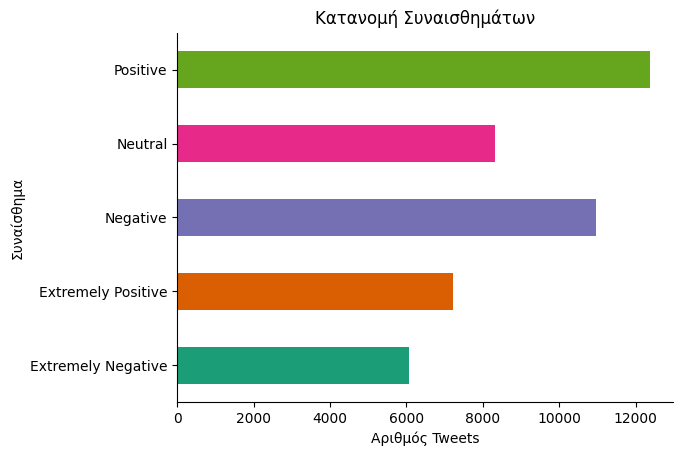

In [ ]:
merged_tweets.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.ylabel('Συναίσθημα')
plt.xlabel('Αριθμός Tweets')
plt.title('Κατανομή Συναισθημάτων')

count    44955.000000
mean        30.703993
std         11.626022
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: tweet_length, dtype: float64


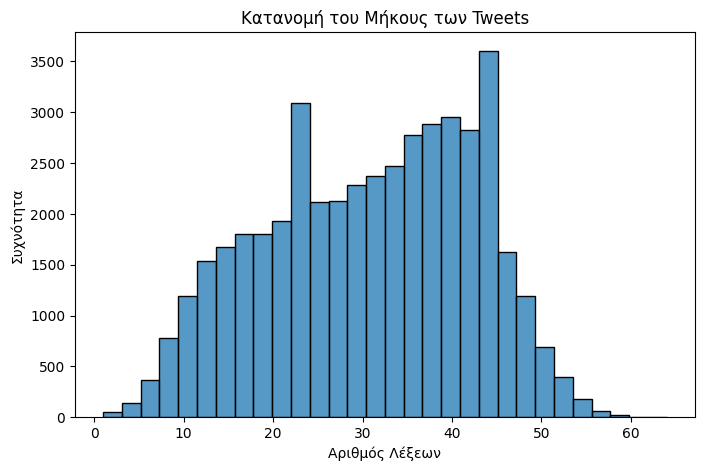

In [ ]:
merged_tweets['tweet_length'] = merged_tweets['OriginalTweet'].apply(lambda x: len(str(x).split()))
print(merged_tweets['tweet_length'].describe())

plt.figure(figsize=(8,5))
sns.histplot(merged_tweets['tweet_length'], bins=30, kde=False)
plt.title('Κατανομή του Μήκους των Tweets')
plt.xlabel('Αριθμός Λέξεων')
plt.ylabel('Συχνότητα')
plt.show()

## Cleaning

In [ ]:
merged_tweets = merged_tweets[['OriginalTweet', 'Sentiment']]

In [ ]:
def strip_emoji(text):
    """Remove emojis from the text."""
    return re.sub(emoji.get_emoji_regexp(), "", text)

def strip_all_entities(text):
    """Remove mentions, URLs, non-ASCII chars, punctuation, and line breaks."""
    text = text.replace('\r', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:@|https?://)\S+", "", text)  # remove mentions and URLs
    text = re.sub(r'[^\x00-\x7f]', '', text)        # remove non-ASCII characters
    banned_chars = string.punctuation + 'Ã±ã¼â»§'
    return text.translate(str.maketrans('', '', banned_chars))

def clean_hashtags(text):
    """Remove trailing hashtags and clean inline ones by stripping # or _."""
    # Remove hashtags at the end of the sentence
    text = re.sub(r'#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#\w+)*\s*$)', '', text)
    # Replace inline '#' and '_' with spaces
    return re.sub(r'[#_]', ' ', text)

def filter_chars(text):
    """Remove words that contain special characters like $ or &."""
    return ' '.join(word for word in text.split() if '$' not in word and '&' not in word)

def remove_mult_spaces(text):
    """Remove multiple consecutive spaces."""
    return re.sub(r'\s{2,}', ' ', text).strip()

In [ ]:
# Combined cleaning function
def clean_tweet(text):
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text

# Apply cleaning to both datasets
merged_tweets['CleanTweet'] = merged_tweets['OriginalTweet'].apply(clean_tweet)

In [ ]:
def number_of_words(text):
  return len(text.split(' '))
merged_tweets['WordsNumber'] = merged_tweets['CleanTweet'].apply(number_of_words)

merged_tweets = merged_tweets[merged_tweets['WordsNumber'] >= 5]

In [ ]:
merged_tweets.head()

,OriginalTweet,Sentiment,CleanTweet,WordsNumber
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39
5,As news of the regionÂs first confirmed COVID...,Positive,as news of the regions first confirmed covid19...,34


In [ ]:
merged_tweets = merged_tweets[['Sentiment', 'CleanTweet']]

In [ ]:
merged_tweets['Sentiment'] = merged_tweets['Sentiment'].map({
    'Extremely Negative':0, 'Negative':0,
    'Neutral':1,
    'Positive':2,'Extremely Positive':2
    })

<ipython-input-12-02c6691da12a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_tweets['Sentiment'] = merged_tweets['Sentiment'].map({


In [ ]:
merged_tweets['Sentiment'].value_counts()

,count
Sentiment,
2,19545
0,17000
1,8182


In [ ]:
merged_tweets_df = merged_tweets.groupby('Sentiment').apply(lambda x: x.sample(3000, random_state=SEED), include_groups=False).reset_index().drop('level_1', axis=1)

In [ ]:
merged_tweets_df

,Sentiment,CleanTweet
0,0,what really annoys me is when i go to the supe...
1,0,right now we may not be able to sedate people ...
2,0,linkedin on thursday said it will offer free j...
3,0,update of working in retail during covid19 and...
4,0,i reckon theyll do a movie about corona virus ...
...,...,...
8995,2,the sampp 500 ended another volatile day down ...
8996,2,please discount the streaming prices its a pub...
8997,2,a big shout out to all those supermarket emplo...
8998,2,here at patchwork we d like to thank those wor...


In [ ]:
merged_tweets_df.to_csv('Balanced_Tweets.csv')